In [24]:
# test code works after changes for serialization 

import librosa

from ddc_onset import FRAME_RATE, compute_onset_salience, find_peaks

type__ =  'slow' # 'perc'  or 'slow'
# audio is (5864816,) in [-1, 1]
# audio, sr = librosa.load('loop.mp3', sr=44100, mono=True)
if type__ == 'perc':
    fnames = [
        'test_samples/Percussion.mp3',
        'test_samples/Piano Recording.wav',
        'test_samples/Electric Bass.wav',
        'test_samples/Scat Singing.mp3'
    ]
else:
    fnames = [
        'test_samples/Flute.wav',
        'test_samples/Church Organ.wav',
        'test_samples/Amp Mod Noise.wav',
        'test_samples/Wine Glass.wav',
        'test_samples/Wobble Bass.wav', # from Distance - Radical
    ]
    


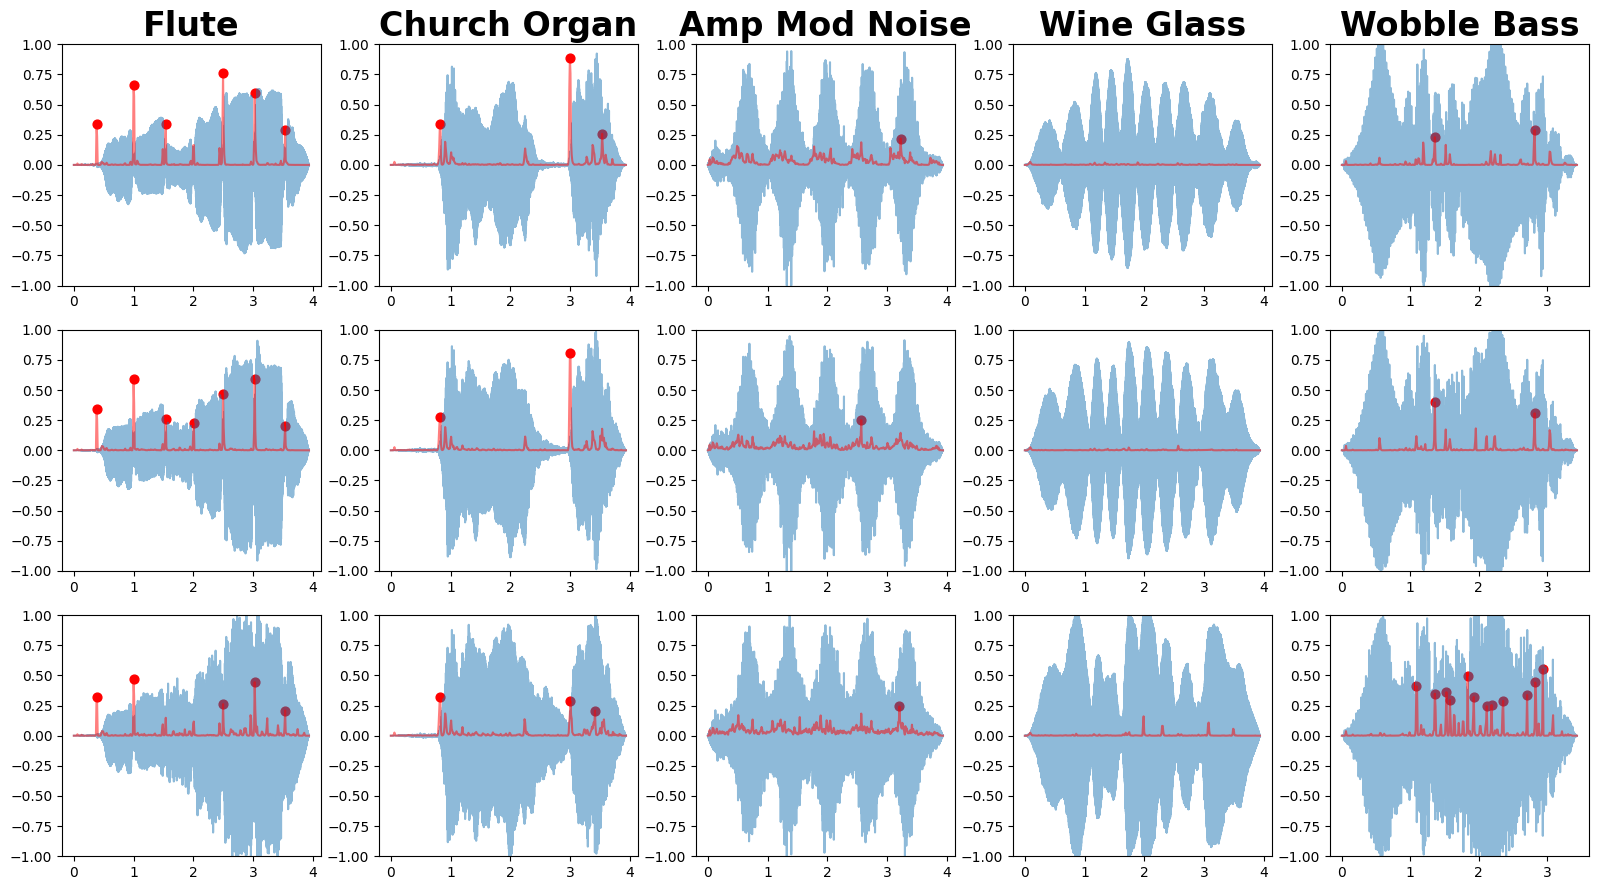

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from ddc_onset import FRAME_RATE, compute_onset_salience, find_peaks

heavy_reverb = 50
reverb_levels = [0, 50, 100]

fig, axs = plt.subplots(len(reverb_levels), len(fnames), figsize=(16, 9  ))

axs = [axs] if len(reverb_levels) == 1 else axs

for i, heavy_reverb in enumerate(reverb_levels):
    for ax, fname in zip(axs[i], fnames):
        audio, sr = librosa.load(fname, sr=44100, mono=True)
        
        from pysndfx import AudioEffectsChain
        # Create an AudioEffectsChain with the supplied effects
        fx = (
            AudioEffectsChain().normalize().reverb(reverberance=heavy_reverb, wet_gain=3)
        )
        
        # Apply the effects and return the results
        audio = fx(audio)
        
        start = int(-5.5 * 512)
        end = start + 4 * 44100
        
        audio2 = audio[:end]
        
        # fade in and fade out
        fade_in = np.linspace(0, 1, 22050)
        
        audio2[:len(fade_in)] *= fade_in
        audio2[-len(fade_in):] *= fade_in[::-1]
        
        
        t = np.arange(len(audio2)) / sr
        
        
        
        ax.plot(t, audio2, alpha=0.5)
        
        # onset salience is (13301,) in [0, 1]
        onset_salience = compute_onset_salience(audio2, sr)
        ax.plot(np.arange(len(onset_salience)) / FRAME_RATE, onset_salience, color='red', alpha=0.5)
        
        # peaks 
        peaks = find_peaks(onset_salience)
        peaks = peaks[onset_salience[peaks] > 0.2]
        ax.scatter(peaks / FRAME_RATE, onset_salience[peaks], color='red', s=40,  marker='o')
        
        # ax.set_xlabel('Time (s)', fontsize=12)
        # ax.set_ylabel('Salience/Amplitude', fontsize=12)
        if heavy_reverb == 0:
            ax.set_title(f'{fname.split("/")[-1].split(".")[0]}', fontsize=24, fontweight='bold')
        ax.set_ylim(-1, 1)
    
plt.tight_layout()

# save plot with upscaled resolution
plt.savefig(f'test_samples/{type__}_onset_salience_Reverb_{heavy_reverb}.png', dpi=300)


In [26]:
from scipy.signal import butter, lfilter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

[112010 135176 157955]
176400
(176400,)
[ 54100  75974  98119 132358 151226 159319]
176400
(176400,)
[ 17257  48098  77441 104729 135825 164747]
176400
(176400,)
[ 28385  47760  60308  72159  84831  98489 112900 129016 150094 169913]
176400
(176400,)
[ 48080  59881  68320  78212 124192 134953 144919]
151552
(151552,)
[112005 158457]
176400
(176400,)
[ 53456  75689 131978 151174]
176400
(176400,)
[ 17153  48130  77497 104898 136421 164895]
176400
(176400,)
[ 30348  49768  61622  73479  86514 100490 114920 131808 151377 170793]
176400
(176400,)
[ 48042  60053  68804  78761 123945 144925]
151552
(151552,)
[158053]
176400
(176400,)
[ 53205  75494 133564 146145 150975]
176400
(176400,)
[ 17069  48423  78103 106857 137959 165216]
176400
(176400,)
[ 30312  51385  60899  73854  86748 101643 113678 131875 153452 169980]
176400
(176400,)
[ 48380  59993 135375 144753]
151552
(151552,)


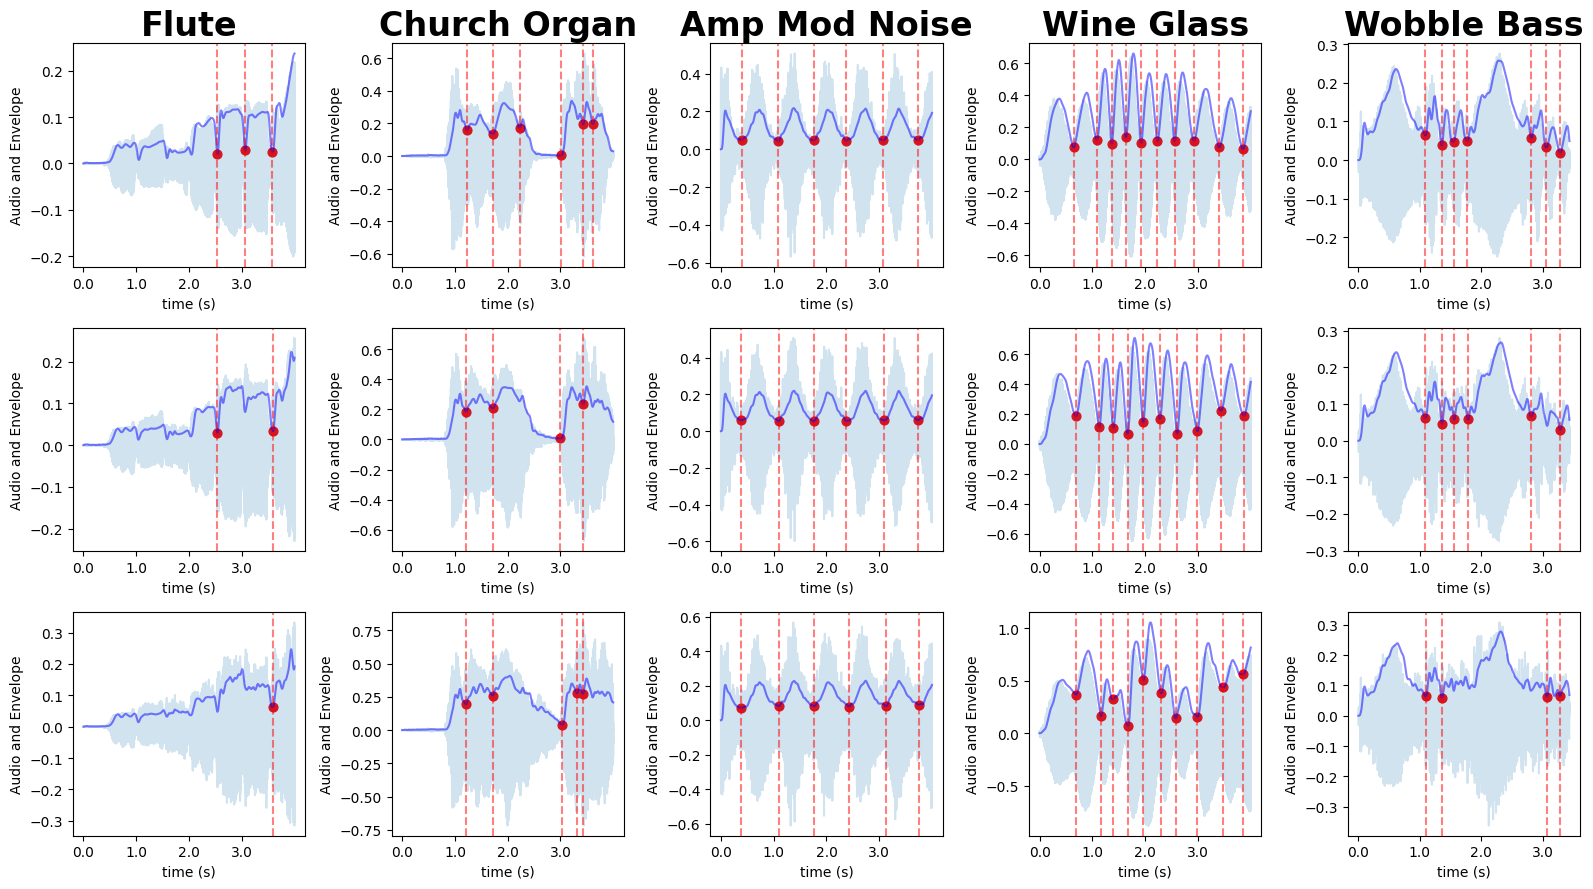

In [42]:
import numpy as np
from scipy.signal import hilbert, chirp
import matplotlib.pyplot as plt

fs = 44100.0 #sampling frequency
duration = 1  #duration of the signal
t = np.arange(int(fs*duration)) / fs #time base
fig, axs = plt.subplots(len(reverb_levels), len(fnames), figsize=(16, 9))

for i, heavy_reverb in enumerate(reverb_levels):
    for ax, fname in zip(axs[i], fnames):
        audio, sr = librosa.load(fname, sr=44100, mono=True)
            
        from pysndfx import AudioEffectsChain
        # Create an AudioEffectsChain with the supplied effects
        fx = (
            AudioEffectsChain().reverb(reverberance=heavy_reverb, wet_gain=3)
        )
        
        # Apply the effects and return the results
        audio = fx(audio)[:44100 * 4]
        
        x = audio.copy()
        
        ax.plot(x, alpha=0.2) #plot the modulated signal
        # x = lowpass_filter(x, 1000, fs)
        
        z= hilbert(x) #form the analytical signal
        
        # low pass the envelope
        
        cutoff = 12
        x = lowpass_filter(x, cutoff, fs)
        
        inst_amplitude = np.abs(z) #envelope extraction
        inst_amplitude = lowpass_filter(inst_amplitude, cutoff, fs)
        inst_phase = np.unwrap(np.angle(z))#inst phase
        inst_freq = np.diff(inst_phase)/(2*np.pi)*fs #inst frequency
        
        #Regenerate the carrier from the instantaneous phase
        regenerated_carrier = np.cos(inst_phase)
        
        ax.plot(inst_amplitude,'b', alpha=0.5); #overlay the extracted envelope
        ax.set_xlabel('time (s)')
        ax.set_ylabel('Audio and Envelope')
        
        # detect troughs that are super prominent
        from scipy.signal import find_peaks
        troughs, _ = find_peaks(-inst_amplitude, prominence=0.05)
        peaks, _ = find_peaks(inst_amplitude, prominence=0.05)
        
        print(troughs)
        
        # plot the troughs at exact points
        ax.scatter(troughs, inst_amplitude[troughs], color='red', s=40,  marker='o')
        # plt.scatter(peaks, inst_amplitude[peaks], color='green', s=20,  marker='o')
        
        #draw a vertical line at the troughs
        for trough in troughs:
            ax.axvline(x=trough, color='red', linestyle='--', alpha=0.5)
            
        # convert x to time
        t = np.arange(len(x)) / fs
        ax.set_xticks(np.arange(0, len(x), 44100), np.arange(0, len(x) / 44100, 1))
            
        # SET TITLE
        if heavy_reverb == 0:
            ax.set_title(f'{fname.split("/")[-1].split(".")[0]}', fontsize=24, fontweight='bold')
        
        # synthesize the troughs using click sounds
        import soundfile as sf
        from scipy.signal import chirp
        from scipy.io.wavfile import write
        
        # create a click sound
        
        # create a sound with clicks at the troughs
        print(len(audio))
        sound = np.zeros(len(audio))
        print(sound.shape)
        
        for i, trough in enumerate(troughs):
            start = trough
            end = start + 100
            sound[start:end] = 1
            
        # write the sound to a file
        
        sf.write(f'test_samples/synthesized_with_clicks/{type__}_troughs_Reverb_{heavy_reverb}.wav', sound, 44100)
        
        # also mix with original audio
        sound = sound + audio
        
        # write the sound to a file
        sf.write(f'test_samples/synthesized_with_clicks/{type__}_troughs_plus_audio_Reverb_{heavy_reverb}_{fname.split("/")[-1].split(".")[0]}.wav', sound, 44100)
        
    
plt.tight_layout()
    
plt.savefig(f'test_samples/{type__}_envelope_from_hilbert.png', dpi=300)
plt.show()

In [28]:
 # synthesize the troughs using click sounds
import soundfile as sf
from scipy.signal import chirp
from scipy.io.wavfile import write

# create a click sound

# create a sound with clicks at the troughs
print(len(audio))
sound = np.zeros(len(audio))
print(sound.shape)
for i, trough in enumerate(troughs):
    start = trough
    end = start + 100
    sound[start:end] = 1
    
# write the sound to a file
sf.write('troughs.wav', sound, 44100)

# also mix with original audio
sound = sound + audio

# write the sound to a file
sf.write('troughs_plus_audio.wav', sound, 44100)


151552
(151552,)


In [29]:
# synthesize the peaks using click sounds
import soundfile as sf
from scipy.signal import chirp
from scipy.io.wavfile import write

# create a click sound

# create a sound with clicks at the troughs
print(len(audio))
sound = np.zeros(len(audio))
print(sound.shape)
for i, peak in enumerate(peaks):
    start = peak
    end = start + 100
    sound[start:end] = 1
    
# write the sound to a file
sf.write('peaks.wav', sound, 44100)

# also mix with original audio
sound = sound + audio

# write the sound to a file
sf.write('peaks_plus_audio.wav', sound, 44100)


151552
(151552,)


In [30]:
# both
import soundfile as sf

# create a click sound

# create a sound with clicks at the troughs
print(len(audio))
sound = np.zeros(len(audio))
print(sound.shape)
for i, peak in enumerate(peaks):
    start = peak
    end = start + 100
    sound[start:end] = 1
    
for i, trough in enumerate(troughs):
    start = trough
    end = start + 100
    sound[start:end] = 1
    
# write the sound to a file
sf.write('peaks_and_troughs.wav', sound, 44100)

# also mix with original audio
sound = sound + audio

# write the sound to a file
sf.write('peaks_and_troughs_plus_audio.wav', sound, 44100)


151552
(151552,)
